In [1]:
pip install pyqsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyqsp: filename=pyqsp-0.2.0-py3-none-any.whl size=68339 sha256=63cd4098f68f894a51db95dd83ccda074de2844f039de16abb942dd3284ad618
  Stored in directory: /root/.cache/pip/wheels/78/ad/7c/91c2a7b106f830157e4f4a328148beb25c016b77704269087b
Successfully built pyqsp


In [2]:
import numpy as np
import pyqsp
from pyqsp import angle_sequence, response
import math as mt
from pyqsp.poly import (polynomial_generators, PolyTaylorSeries, PolyCosineTX)
from pyqsp.LPoly import PolynomialToLaurentForm
import matplotlib.pyplot as plt

In [8]:
# Specify definite-parity target function for QSP.
func = lambda x: np.cos(3*x)
polydeg = 12 # Desired QSP protocol length.
max_scale = 0.9 # Maximum norm (<1) for rescaling.
true_func = lambda x: max_scale * func(x) # For error, include scale.

"""
With PolyTaylorSeries class, compute Chebyshev interpolant to degree
'polydeg' (using twice as many Chebyshev nodes to prevent aliasing).
"""
poly = PolyTaylorSeries().taylor_series(
    func=func,
    degree=polydeg,
    max_scale=max_scale,
    chebyshev_basis=False,
)

poly_coefs = poly.coef.copy()
# Set odd coefficients to zero to ensure definite parity.
poly_coefs[1::2] = 0

poly_even = type(poly)(poly_coefs)

laurent_poly = PolynomialToLaurentForm(poly_even.coef)

# Compute full phases (and reduced phases, parity) using symmetric QSP.
(phiset) = angle_sequence.QuantumSignalProcessingPhases(
    laurent_poly,
    method='laurent',
    chebyshev_basis=False,
)
"""
Plot response according to full phases.
Note that `pcoefs` are coefficients of the approximating polynomial,
while `target` is the true function (rescaled) being approximated.
"""
response.PlotQSPResponse(
    phiset,
    pcoefs=laurent_poly,
    plot_probability=True,
    target=true_func,
    sym_qsp=True,
    plot_real_only=False,
    simul_error_plot=True
)



[PolyTaylorSeries] (Cheb) max 0.9000000052343544 is at 2.3442345873938366e-07: normalizing
[PolyTaylorSeries] (Cheb) average error = 3.369107902002899e-09 in the domain [-1, 1] using degree 12


ValueError: Must provide Chebyshev coefficient list/array, or Chebyshev polynomial object.

Maximum absolute error between Re[U(0,0)] and target function: 1.781847399602905


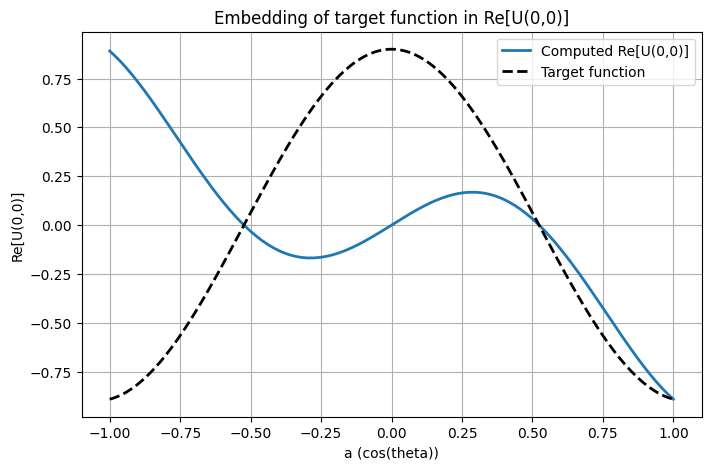

In [4]:
##############################################################################
# 1. Define the W_z operator and the X-rotation operator
##############################################################################

def W_z(a):
    """
    'Wz' convention operator for QSP:
      W_z(a) = diag(a + i sqrt(1-a^2), a - i sqrt(1-a^2)).
    This is a Z-rotation-like matrix encoding the signal 'a' in the diagonal.
    """
    sqrt_term = np.sqrt(1 - a*a)
    return np.array([
        [a + 1j*sqrt_term, 0],
        [0,               a - 1j*sqrt_term]
    ], dtype=complex)

def X_rotation(phi):
    """
    X-rotation operator: exp(i phi X).

    In the standard basis, e^{i phi X} =
        [[ cos(phi),  i sin(phi)],
         [ i sin(phi), cos(phi)]]
    (One can confirm this by the usual 2x2 matrix exponential of i*phi*X.)
    """
    c = np.cos(phi)
    s = np.sin(phi)
    return np.array([
        [    c,  1j*s],
        [ 1j*s,    c ]
    ], dtype=complex)

##############################################################################
# 2. Build the QSP unitary from a full list of phases in the W_z convention
##############################################################################

def build_unitary_wz(a, phases):
    """
    Given:
      - a in [-1, 1],
      - phases: a list/array [phi_0, phi_1, ..., phi_N],
    build the QSP unitary U_z(a) in the 'Wz' convention:

       U_z(a) = X_rotation(phi_0) W_z(a)
                 X_rotation(phi_1) W_z(a)
                 ...
                 X_rotation(phi_N) W_z(a)

    Returns a 2x2 complex matrix.
    """
    U = np.eye(2, dtype=complex)
    for phi in phases:
        U = X_rotation(phi) @ W_z(a) @ U
    return U

##############################################################################
# 3. Example usage:
#    - We'll define some arbitrary 'phases' for demonstration.
#    - We'll build the QSP unitary for each a in [-1,1].
#    - We'll plot the imaginary part of U[0,0].
##############################################################################

if __name__ == "__main__":
    # Suppose we already have a full list of phases from a QSP solver or a random guess
    full_phases = [0.2, -0.15, 0.3, 0.1]  # arbitrary example

    a_vals = np.linspace(-1, 1, 200)
    U00_real = []
    for a in a_vals:
        U = build_unitary_wz(a, phiset)
        U00_real.append(np.real(U[0,0]))

    U00_real = np.array(U00_real)
    target_vals = true_func(a_vals)

    # Compute the maximum absolute error.
    max_error = np.max(np.abs(U00_real - target_vals))
    print("Maximum absolute error between Re[U(0,0)] and target function:", max_error)

    # ============================================================================
    # 9. Plot the comparison.
    # ============================================================================
    plt.figure(figsize=(8,5))
    plt.plot(a_vals, U00_real, label="Computed Re[U(0,0)]", linewidth=2)
    plt.plot(a_vals, target_vals, 'k--', label="Target function", linewidth=2)
    plt.xlabel("a (cos(theta))")
    plt.ylabel("Re[U(0,0)]")
    plt.title("Embedding of target function in Re[U(0,0)]")
    plt.legend()
    plt.grid(True)
    plt.show()